In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive/MyDrive/LabFinal/Medical_Image_Classification/'
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/LabFinal/Medical_Image_Classification
CNN_dataset  MedNetV2.onnx  requirements.txt


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [ ]:
dataDir = 'CNN_dataset'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames

numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])

numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image



print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 50020 images in 5 distinct categories
Label names: ['ChestCT', 'AbdomenCT', 'HeadCT', 'Hand', 'CXR']
Label counts: [10020, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


0 9821
1 17432
2 34887
3 38875
4 18811
5 16483
6 43365
7 48057
8 13767


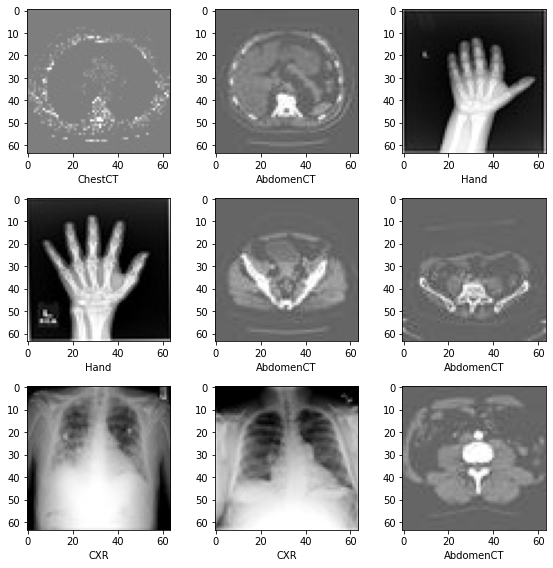

In [ ]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

In [ ]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

In [ ]:
lenn = int(len(imageFilesList)/5)
imageTensor = torch.stack([scaleImage(Image.open(imageFilesList[k])) for i,k in enumerate(np.random.randint(numTotal, size=10000))])  
# Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.945; Mean = -2.91e-09


In [121]:
!nvidia-smi

Tue Mar 14 20:45:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |   1819MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [122]:
validFrac = 0.2   # Define the fraction of images to move to validation dataset
testFrac = 0.2    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(int(10000)):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)

Training images = 5989 Validation = 2019 Testing = 1992


In [123]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    # training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

In [142]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        
        numConvs1 = 10
        convSize1 = 5
        numConvs2 = 20
        convSize2 = 5

        
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))


        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        
        fcSize1 = 400
        fcSize2 = 80
        

        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.full1_bn = nn.BatchNorm1d(20)
        # self.dropout = nn.Dropout(p=0.2)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        # self.dropout = nn.Dropout(p=0.2)
        self.full2_bn = nn.BatchNorm1d(50)
        self.ful3 = nn.Linear(fcSize2,numC)


    def forward(self,x):

        
        x = F.relu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.relu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        # x = F.relu(self.cnv3(x))
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.relu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.relu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [147]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

In [ ]:
learnRate = 0.05         
maxEpochs = 5            
t2vRatio = 1.5            
t2vEpochs = 4             
batchSize = 64           
trainBats = nTrain // batchSize       
validBats = nValid // batchSize      
testBats = -(-nTest // batchSize)     

CEweights = torch.zeros(numClass)     
for i in trainY.tolist():             
    CEweights[i].add_(1)              
CEweights = 1. / CEweights.clamp_(min=1.)                     
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  
opti = om.SGD(model.parameters(), lr = learnRate)   


for i in range(maxEpochs):
    model.train()                     
    epochLoss = 0.
    permute = torch.randperm(nTrain)  
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        
        opti.zero_grad()              
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         
        yOut = model(batX)           
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        
        epochLoss += loss.item()      
        loss.backward()              
        opti.step()                   
    validLoss = 0.
    permute = torch.randperm(nValid)  
    validX = validX[permute,:,:,:]    
    validY = validY[permute]
    model.eval()                      
    with torch.no_grad():             
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break
    

In [149]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)

Correct predictions:  1992 of 1992
Confusion Matrix:
[[1992    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]
['ChestCT', 'AbdomenCT', 'HeadCT', 'Hand', 'CXR']


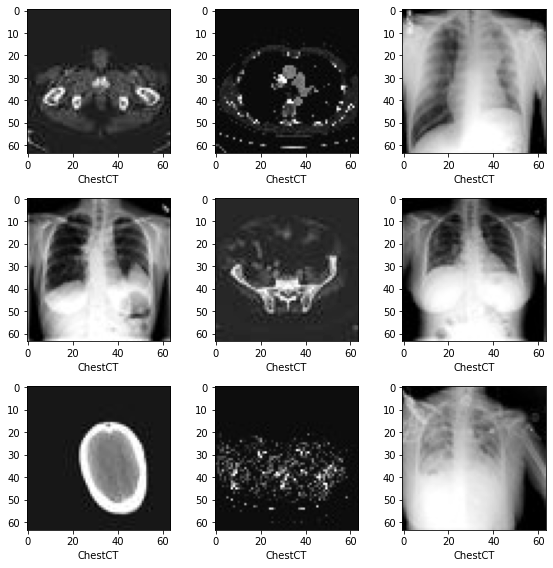

In [135]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    
    for i, y in enumerate(batY.tolist()):
        if imagesLeft:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
          
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()